In [1]:
import phenograph
import pandas as pd
import numpy as np
import community
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from random import shuffle
import pickle
import time


In [ ]:
aml = pd.read_csv('../Data/AML_benchmark.csv')

In [ ]:
data = data.loc[data['cell_type'] != 'NotDebrisSinglets']

data = data.drop(axis='columns', labels=["Time", "Cell_length", "DNA1", "DNA2",
                                       "Viability", "file_number", "event_number", "subject"])
datalabels = pd.DataFrame(data['cell_type'])

data = data.drop(axis='columns', labels="cell_type")

Arcsin transform

In [5]:
data = np.arcsinh((data-1)/5)


In [6]:
data.shape

(104184, 32)

Call phenograph

In [7]:
communities, graph, Q = phenograph.cluster(data.values)


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 228.59529542922974 seconds
Jaccard graph constructed in 23.35639238357544 seconds
Wrote graph to binary file in 11.527968883514404 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.872971
After 2 runs, maximum modularity is Q = 0.873987
Louvain completed 22 runs in 148.53066039085388 seconds
PhenoGraph complete in 414.9299306869507 seconds


In [10]:
#Create nx graph from phenograph graph data
tic = time.clock()
nxgraph = nx.Graph(graph)
#Call Louvain community method without phenograph
louvain_communities = community.best_partition(nxgraph)
louvainpd = pd.DataFrame(pd.Series(louvain_communities))
louvainpd.columns = ['community']
louvainpd['node'] = louvainpd.index
louvainpd = pd.DataFrame(louvainpd.groupby("community").count()).sort_values(by=['node'], ascending=False)
louvainpd['community'] = louvainpd.index
toc = time.clock()
print(toc-tic)

1110.605157


In [11]:
#pickle louvain en phenograph resultaten
with open('phenocommunities.pickle', 'wb') as handle:
    pickle.dump(communities, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('louvaincommunities.pickle', 'wb') as handle:
    pickle.dump(louvain_communities, handle, protocol=pickle.HIGHEST_PROTOCOL)

tSNE of raw data

In [ ]:
import time
start_time = time.time()
raw_embedded = TSNE(n_components=2).fit_transform(data.values)
print("--- %s seconds ---" % (time.time() - start_time))
--- 3395.5248770713806 seconds ---
transposed = raw_embedded.transpose()
x = transposed[0]
y = transposed[1]


In [26]:
Louvain & phenograph communities from pickle
infile = open('phenocommunities.pickle','rb')
phenopd = pickle.load(infile)
infile.close()
infile = open('louvaincommunities.pickle','rb')
louvainpd = pickle.load(infile)
infile.close()

In [27]:
louvainlist = [louvainpd[i] for i in louvainpd.keys()]


In [28]:
plt.rcParams['figure.figsize'] = [30, 15]
fig, ax = plt.subplots(1, 3)


In [29]:
labelset = list(set(labels))
colors = []
norm = Normalize(vmin=0, vmax=13)
cmap = plt.cm.get_cmap('Spectral')
for i in range(14):
    colors.append(cmap(norm(i)))
#shuffle(colors)

In [30]:
ax[0].scatter(x,y, s=2, c=[colors[labelset.index(i)] for i in labels])
ax[0].set_xlabel("TSNE 1")
ax[0].set_ylabel("TSNE 2")

handles = []
for i in range(14):
    handles.append(Patch(facecolor=colors[i]))
ax[0].legend(handles, labelset, loc='upper right', prop={'size': 5}, framealpha=0.5)
ax[0].set_title("TSNE of gated labels")


Text(0.5,1,'TSNE of gated labels')

In [31]:
labelset = list(set(communities))
colors = []
norm = Normalize(vmin=0, vmax=len(labelset)-1)
cmap = plt.cm.get_cmap('Spectral')
for i in range(len(labelset)):
    colors.append(cmap(norm(i)))
#shuffle(colors)
ax[1].scatter(x,y, s=2, c=[colors[i] for i in communities])
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
handles = []
for i in range(len(labelset)-1):
    handles.append(Patch(facecolor=colors[i]))
ax[1].legend(handles, labelset, loc='upper right', prop={'size': 7}, framealpha=0.5)
ax[1].set_title("Phenograph clusters plotted on TSNE space")




Text(0.5,1,'Phenograph clusters plotted on TSNE space')

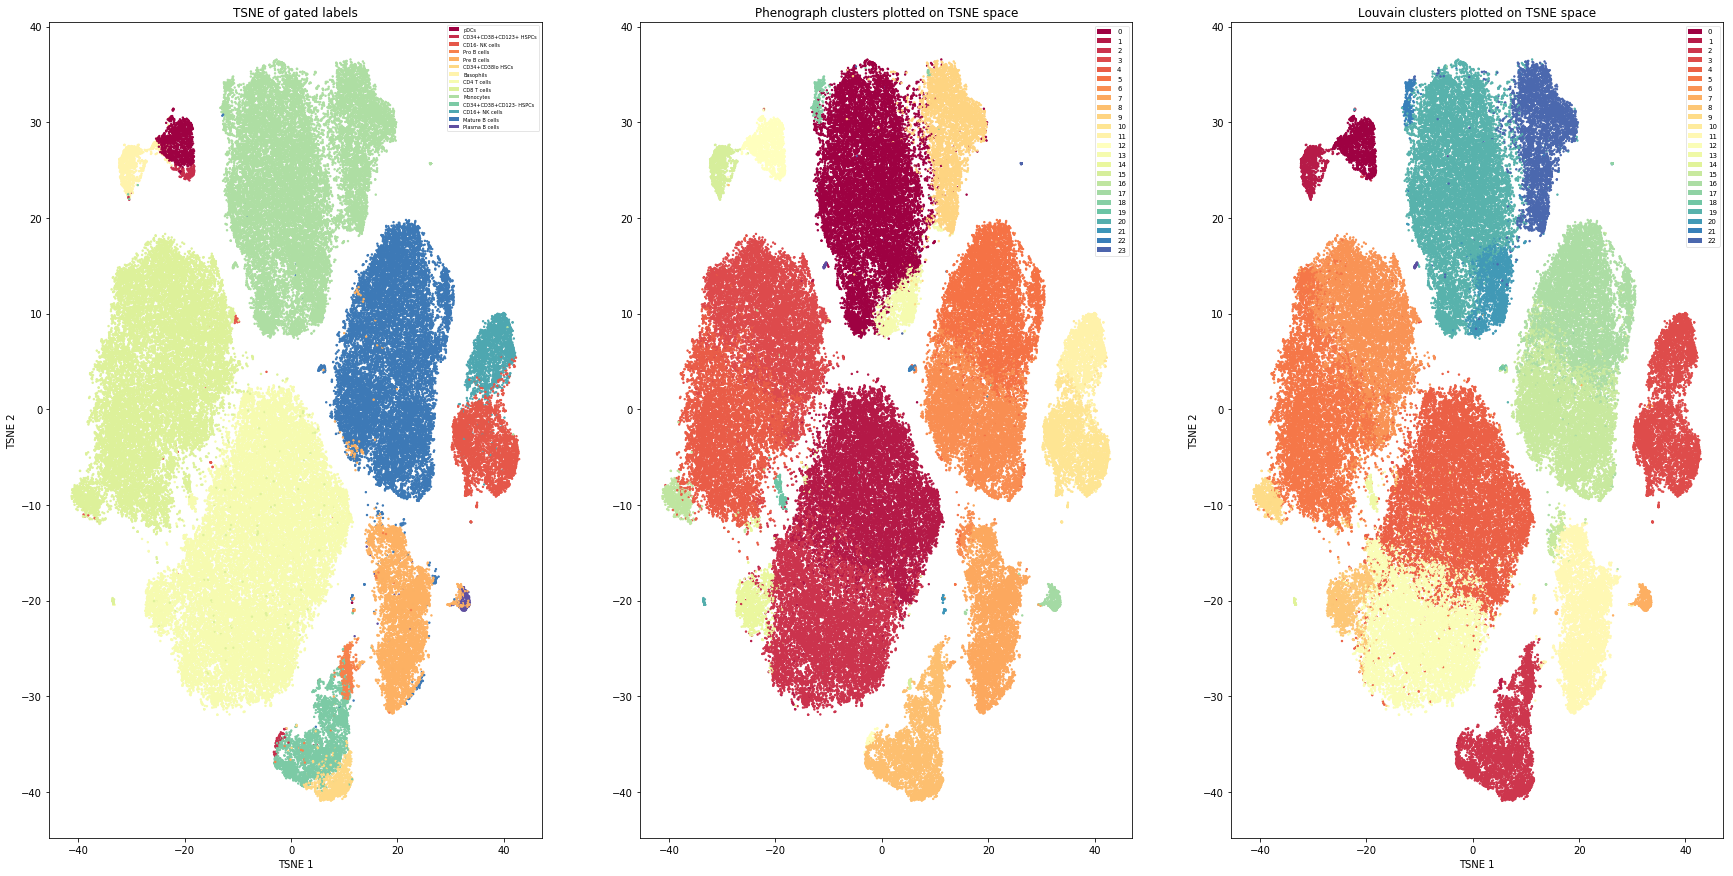

In [32]:
labelset = list(set(louvainlist))
colors = []
norm = Normalize(vmin=0, vmax=len(labelset)-1)
cmap = plt.cm.get_cmap('Spectral')
for i in range(len(labelset)):
    colors.append(cmap(norm(i)))
#shuffle(colors)

ax[2].scatter(x,y, s=2, c=[colors[i] for i in louvainlist])
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
handles = []
for i in range(len(labelset)-1):
    handles.append(Patch(facecolor=colors[i]))
plt.legend(handles, labelset, loc='upper right', prop={'size': 7}, framealpha=0.5)

ax[2].set_title("Louvain clusters plotted on TSNE space")
plt.show()


In [33]:
plt.clf()

In [34]:
# data = pd.read_csv("../../LDA/Data/AML_benchmark.csv", header=0)
# data = data.loc[data['cell_type'] != 'NotDebrisSinglets']

# data = data.drop(axis='columns', labels=["Time", "Cell_length", "DNA1", "DNA2",
#                                        "Viability", "file_number", "event_number", "subject"])

# data.head()